In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
#import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

In [ ]:
jax.config.update('jax_platform_name', 'cpu')
jax.default_backend()


'cpu'

In [114]:
#generate data

x_a = np.linspace(-4, 4, 25)
y_a = np.linspace(-4,4, 25)
theta_a = np.linspace(0,2*np.pi, 15)

x_d = np.linspace(0,0, 1)
y_d = np.linspace(0,0, 1)
theta_d = np.linspace(0.,0., 1)

xx_a, yy_a, tt_a, xx_d, yy_d, tt_d = np.meshgrid(x_a, y_a, theta_a, x_d, y_d, theta_d)
grid = np.vstack([xx_a.ravel(), yy_a.ravel(), tt_a.ravel(), xx_d.ravel(), yy_d.ravel(), tt_d.ravel()]).T



In [115]:
grid

array([[-4.        , -4.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-4.        , -4.        ,  0.44879895,  0.        ,  0.        ,
         0.        ],
       [-4.        , -4.        ,  0.8975979 ,  0.        ,  0.        ,
         0.        ],
       ...,
       [ 4.        ,  4.        ,  5.38558741,  0.        ,  0.        ,
         0.        ],
       [ 4.        ,  4.        ,  5.83438636,  0.        ,  0.        ,
         0.        ],
       [ 4.        ,  4.        ,  6.28318531,  0.        ,  0.        ,
         0.        ]])

In [116]:
X = []
env = TwoPlayerDubinsCarEnv()
for g in grid:
    state = env.set(*g)
    X.append(state.copy())


In [117]:
y_true = [env.get_attacker_max_reward(state) for state in X]
y_true = np.array(y_true)
y_true[y_true == -np.inf] = -1
print(sum(y_true))

1067.584240867875


In [118]:
y_true.shape

(9375,)

In [119]:
X[2000]

{'attacker': array([-1.3333334, -2.3333333,  2.2439947], dtype=float32),
 'defender': array([0., 0., 0.], dtype=float32)}

In [120]:
import matplotlib.colors as mcolors

def plot_surface(X_in, env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((0, 0), 0.5, color='r', fill=False) #defemder
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)

    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        norm = mcolors.Normalize(vmin=np.min(y_pred), vmax=np.max(y_pred))
        arrow_colors = cm.jet(norm(y_pred))
    elif len(ys) > 0:
        norm = mcolors.Normalize(vmin=np.min(ys), vmax=np.max(ys))
        arrow_colors = cm.jet(norm(ys))
    else:
        arrow_colors = 'k'

    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)

    if file_name:
        plt.savefig(file_name)


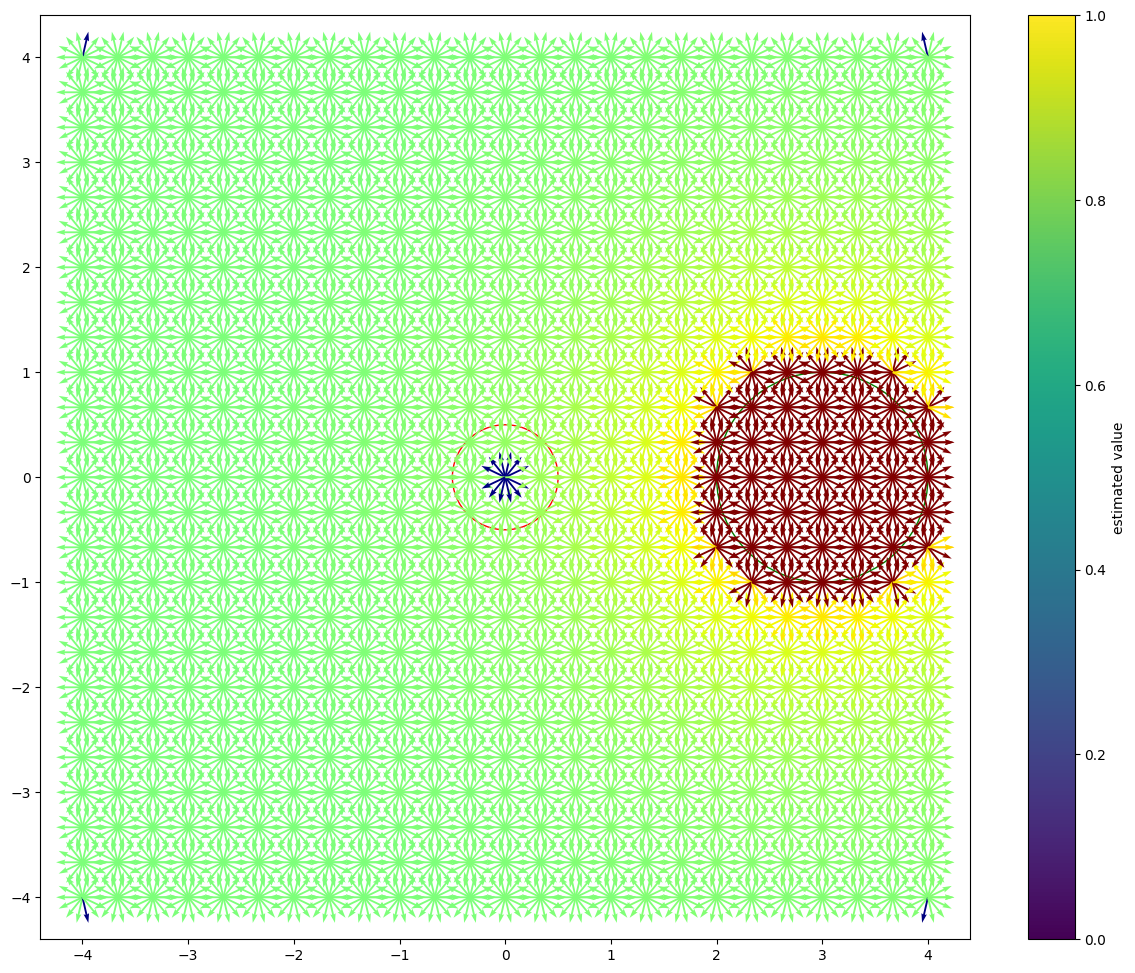

In [121]:
X_attacker = np.array([x['attacker'] for x in X])
plot_surface(X_attacker, env, 'train2.png', [], y_true)

In [122]:
X[:5]

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([0., 0., 0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([0., 0., 0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([0., 0., 0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([0., 0., 0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([0., 0., 0.], dtype=float32)}]

In [123]:
X = [env.encode_state_big(x) for x in X]
X[:5]

[array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.5       ,
         0.5       ,  1.        ,  0.        ,  1.00778222,  0.86824314,
         0.70710678,  0.70710678, -0.70710678]),
 array([ 0.        ,  0.        ,  0.90096885,  0.43388376,  0.5       ,
         0.5       ,  1.        ,  0.        ,  1.00778222,  0.99752666,
         0.70710678,  0.94388333, -0.70710678]),
 array([ 0.        ,  0.        ,  0.6234898 ,  0.7818315 ,  0.5       ,
         0.5       ,  1.        ,  0.        ,  1.00778222,  0.92923778,
         0.70710678,  0.99371221, -0.70710678]),
 array([ 0.        ,  0.        ,  0.22252098,  0.9749279 ,  0.5       ,
         0.5       ,  1.        ,  0.        ,  1.00778222,  0.67690201,
         0.70710678,  0.84672422, -0.70710678]),
 array([ 0.        ,  0.        , -0.22252095,  0.9749279 ,  0.5       ,
         0.5       ,  1.        ,  0.        ,  1.00778222,  0.29049741,
         0.70710678,  0.53203206, -0.70710678])]

In [124]:
def encode(X):
    X = np.array(list(map(lambda row: (row['attacker'][0], row['attacker'][1], np.cos(row['attacker'][2]), np.sin(row['attacker'][2]), row['defender'][0], row['defender'][1], np.cos(row['defender'][2]), np.sin(row['defender'][2])), X)))
    return X

# def encode(X):
#     min_value = -4
#     max_value = 4

#     X = np.array(list(map(lambda row: (
#         (row['attacker'][0] - min_value) / (max_value - min_value),
#         (row['attacker'][1] - min_value) / (max_value - min_value),
#         np.cos(row['attacker'][2]),
#         np.sin(row['attacker'][2]),
#         (row['defender'][0] - min_value) / (max_value - min_value),
#         (row['defender'][1] - min_value) / (max_value - min_value),
#         np.cos(row['defender'][2]),
#         np.sin(row['defender'][2])), X)))

#     return X


# X = encode(X)
# X


In [125]:
print(len(X))


9375


In [126]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(50000):
#     for player in env.players:
#         state = env.reset()
#         X.append(np.hstack([state['attacker'], state['defender']]))


# X = np.array(X)



In [127]:
X = np.array(X)

In [128]:
X.shape

(9375, 13)

/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/matplotlib/colors.py:1353: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


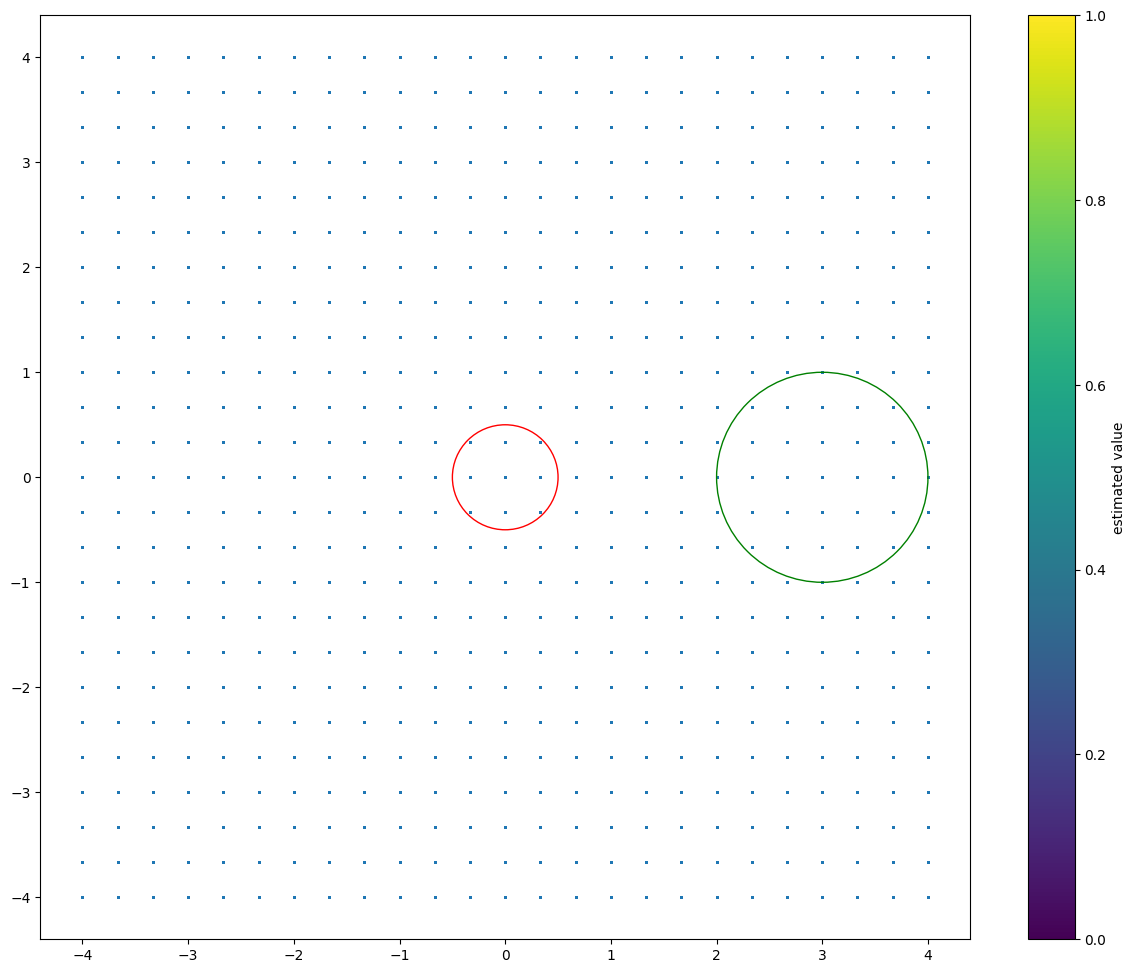

In [129]:
decode_debug = np.array([env.decode_state_big(x)['attacker'] for x in X])
y_true_debug = np.array([env.get_attacker_max_reward(env.decode_state_big(state)) for state in X])
plot_surface(decode_debug, env, 'train3.png', [], y_true_debug)

In [130]:
y_true.round(5) == y_true_debug.round(5)

array([ True,  True,  True, ...,  True,  True,  True])

In [131]:
y_true_debug

array([0.00039124, 0.00040449, 0.00039743, ..., 0.02066526, 0.02064544,
       0.01708243])

In [134]:
X_attacker[600]

array([ 1.       , -3.6666667,  0.       ], dtype=float32)

In [135]:
decode_debug[600]

array([ 1.        , -3.66666675,  0.        ])

In [136]:
#leajy relu made defender really good
# def forward(X):
#     l1 = hk.Linear(128)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(128)(l2)
#     l4 = jax.nn.relu(l3)
#     l5 = hk.Linear(128)(l4)
#     l6 = jax.nn.relu(l5)


#     l7 = hk.Linear(1)(l6)
#     return l7

# def forward(X):
#     l1 = hk.Linear(256)(X)
#     l2 = jax.nn.leaky_relu(l1)
#     l3 = hk.Linear(256)(l2)
#     l4 = jax.nn.leaky_relu(l3)
#     l5 = hk.Linear(256)(l4)
#     l6 = jax.nn.leaky_relu(l5)

#     l7 = hk.Linear(256)(l6)
#     l8 = jax.nn.leaky_relu(l7)

#     l9 = hk.Linear(1)(l8)
#     return l9


def forward(X):
    l1 = hk.Linear(32)(X)
    l2 = jax.nn.leaky_relu(l1)
    l3 = hk.Linear(64)(l2)
    l4 = jax.nn.leaky_relu(l3)
    l5 = hk.Linear(32)(l4)
    l6 = jax.nn.leaky_relu(l5)

    l7 = hk.Linear(1)(l6)
    return l7


# def forward(X):
#     l1 = hk.Linear(128)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(128)(l2)
#     l4 = jax.nn.relu(l3)
#     l5 = hk.Linear(128)(l4)
#     l6 = jax.nn.relu(l5)

#     l7 = hk.Linear(128)(l6)
#     l8 = jax.nn.relu(l7)

#     l9 = hk.Linear(1)(l8)
#     return l9

# def forward(X):
#     l1 = hk.Linear(256)(X)
#     l2 = jax.nn.tanh(l1)
#     l3 = hk.Linear(256)(l2)
#     l4 = jax.nn.tanh(l3)
#     l5 = hk.Linear(256)(l4)
#     l6 = jax.nn.tanh(l5)

#     l7 = hk.Linear(256)(l6)
#     l8 = jax.nn.tanh(l7)

#     l9 = hk.Linear(1)(l8)
#     return l9



# def forward(X):
#     l1 = hk.Linear(128)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(128)(l2)
#     l4 = jax.nn.relu(l3)
#     l5 = hk.Linear(128)(l4)
#     l6 = jax.nn.relu(l5)

#     l7 = hk.Linear(128)(l6)
#     l8 = jax.nn.relu(l7)

#     l9 = hk.Linear(1)(l8)
#     return l9

# import haiku as hk
# import jax.numpy as jnp
# import jax

# def residual_block(x, n_units):
#     h = x
#     h = hk.Linear(n_units)(h)
#     h = jax.nn.leaky_relu(h)
#     h = hk.Linear(n_units)(h)
#     return x + h

# def forward(X):
#     l1 = hk.Linear(128)(X)
#     l2 = jax.nn.leaky_relu(l1)

#     # Add residual blocks
#     l3 = residual_block(l2, 128)
#     l4 = jax.nn.leaky_relu(l3)
#     l5 = residual_block(l4, 128)
#     l6 = jax.nn.leaky_relu(l5)
#     l7 = residual_block(l6, 128)
#     l8 = jax.nn.leaky_relu(l7)

#     # Output layer
#     l9 = hk.Linear(1)(l8)
#     return l9




/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker reward 1
attaker rew

KeyboardInterrupt: 

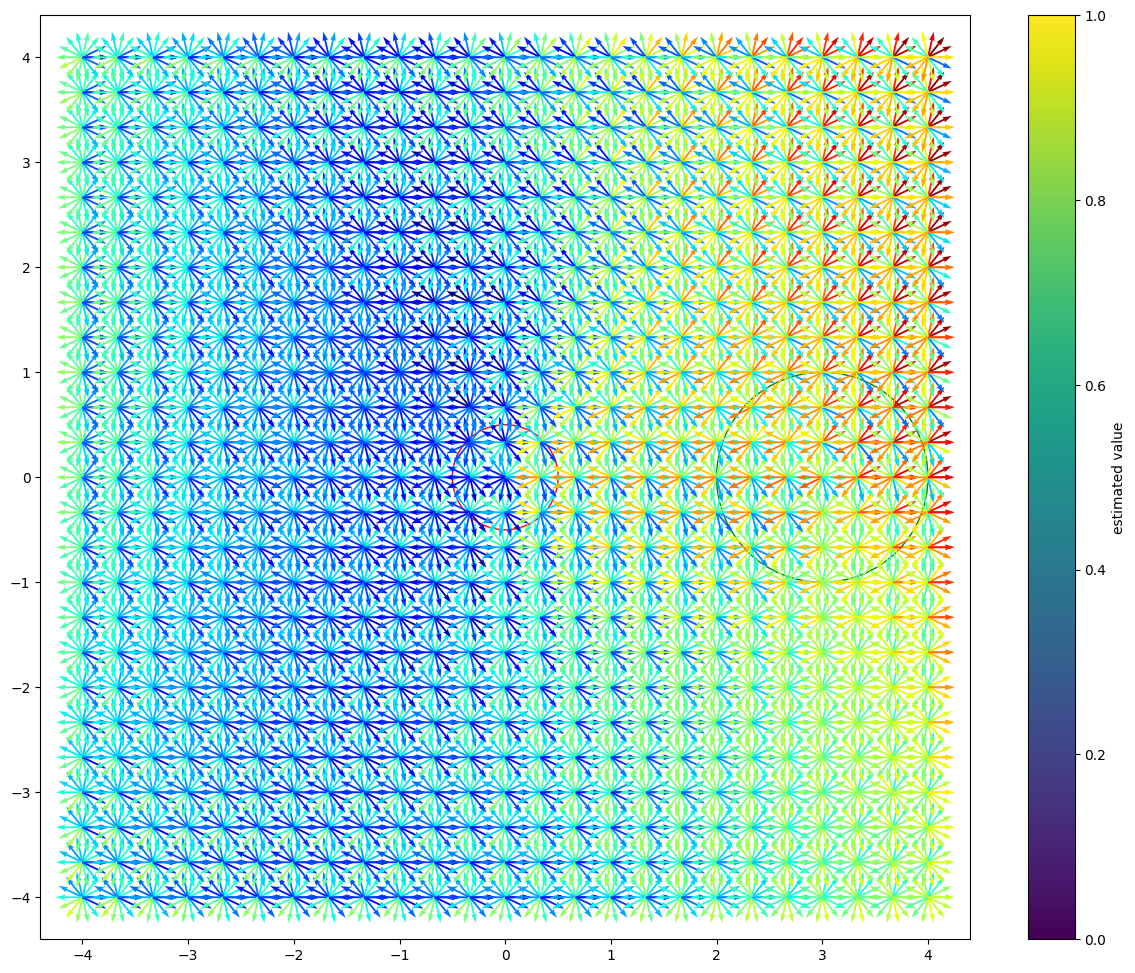

In [137]:
%matplotlib inline


# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=1)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.9

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = False

for epoch in range(20):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        print(batch)


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)

    delta = epoch_loss - losses[-1]
    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', delta)
    losses.append(epoch_loss)
    
    y_train = [forward(X=x, params=params) for x in X]
    plot_surface(X_attacker, env, 'experiment_run.png', y_train)
    if delta > 0.0001:
        print("early stopping", delta)
        break

#todo impolement val set for early stopping


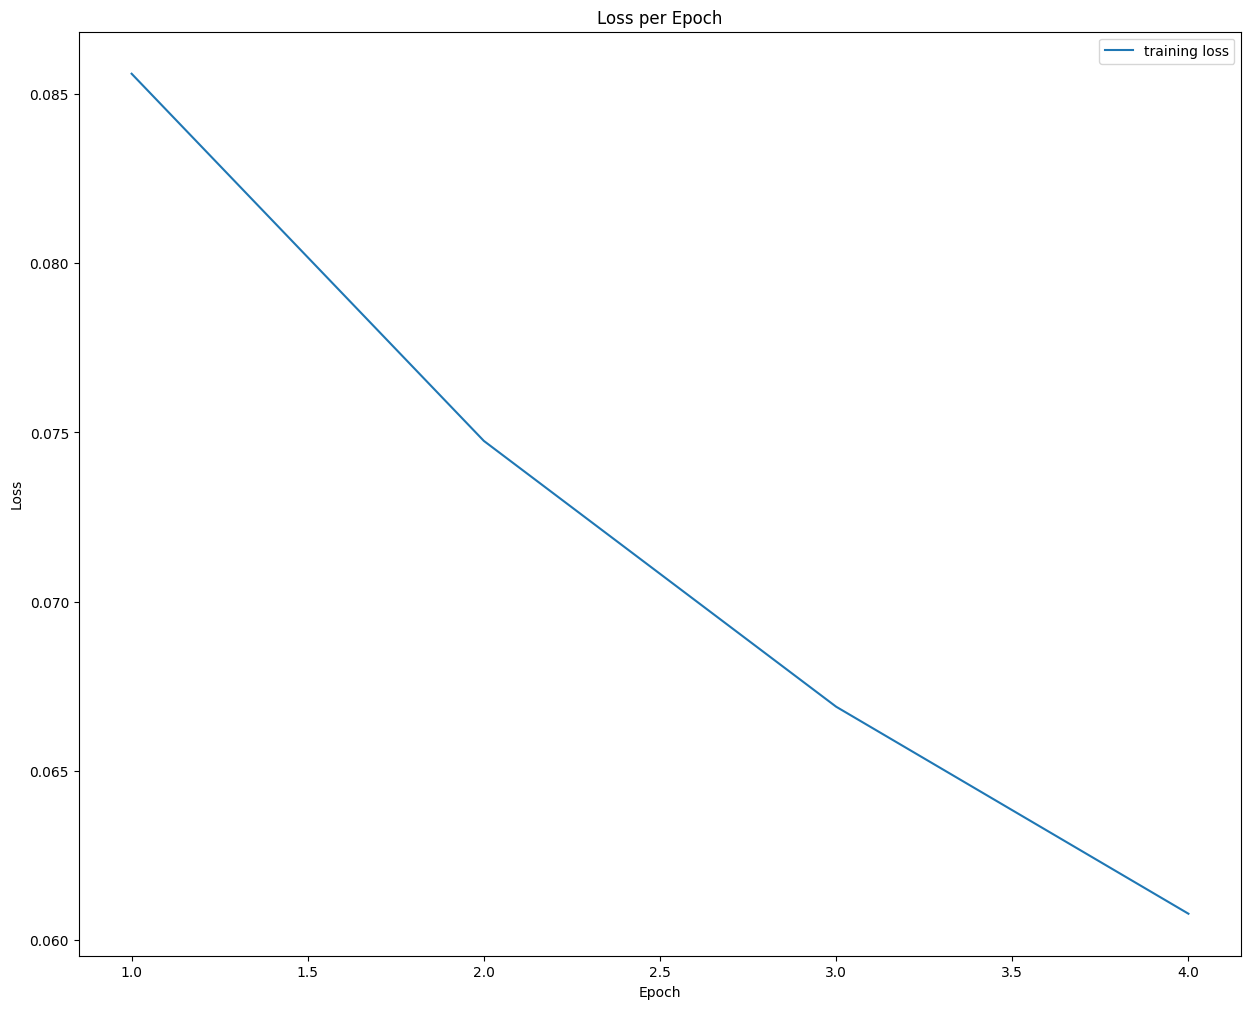

In [138]:
# Plot the losses
%matplotlib inline



plt.plot(losses, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot

plt.show()

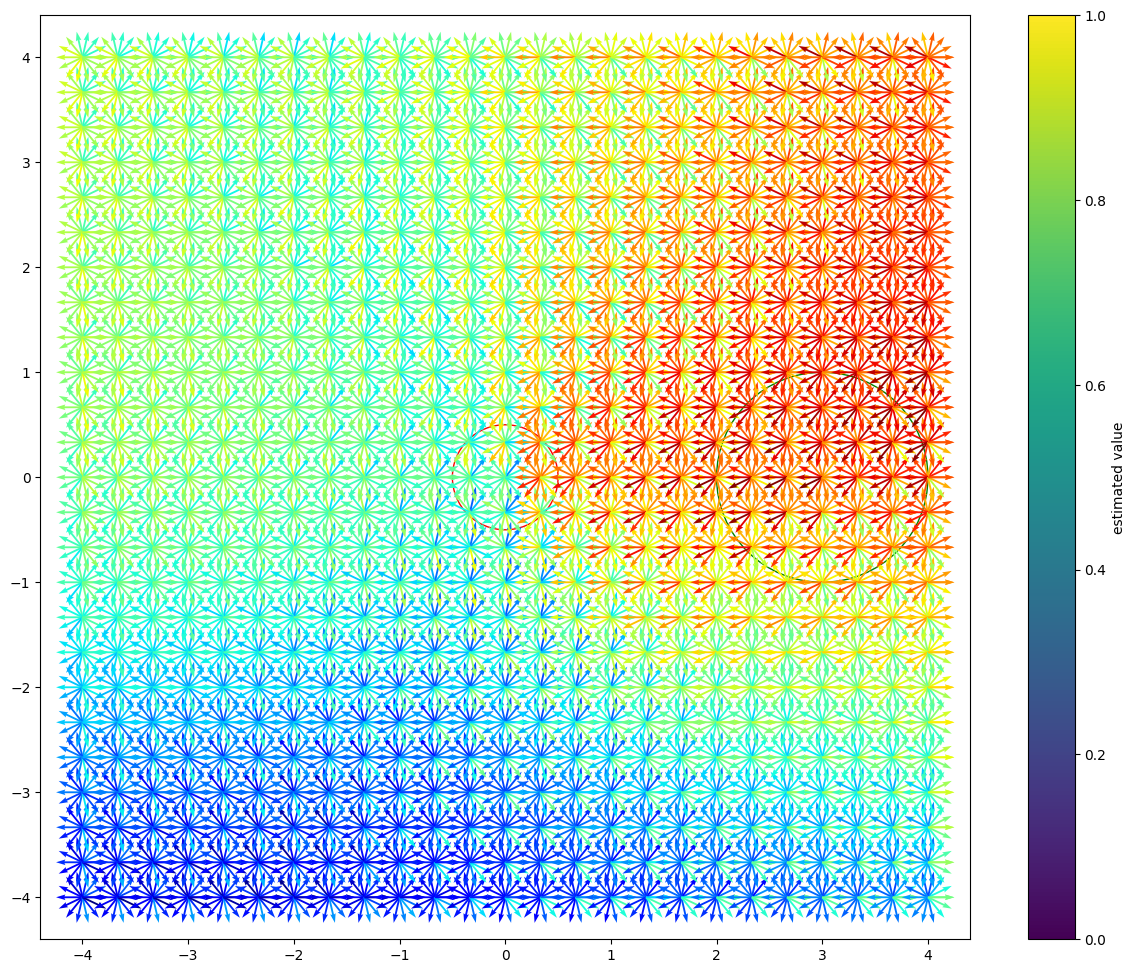

In [428]:

y_train = [forward(X=x, params=params) for x in X]
plot_surface(X_attacker, env, 'experiment2.png', y_train)

In [429]:
# env = TwoPlayerDubinsCarEnv()
# state = env.reset()
# done = False
# max_iter = 50
# counter = 0
# print(env.state)
# while (not done) and (counter < max_iter):
#     counter+=1
#     possible_actions = []
#     for d_action in range(env.action_space['defender'].n):
#         state_ , reward, done, info = env.step(state, d_action, 'defender')
#         defender_actions = []
#         for a_action in range(env.action_space['attacker'].n):
#             next_state, reward, _, _ = env.step(state_, a_action, 'attacker')
#             #input = np.hstack([next_state['attacker'], next_state['defender']])
#             nn_input = env.state_for_nn(next_state)
#             estimate  = forward(X=nn_input, params=params)
#             print('estimate', estimate, 'actual', reward)
#             possible_actions.append([d_action, a_action, estimate[0]])
#         pa = np.array(possible_actions)
#     cand_attack_actions = np.argmax(pa.T,axis=0)
#     best_defender_action =  np.argmin(np.max(pa.T,axis=0))
#     best_attacker_action = cand_attack_actions[best_defender_action]
#     print(counter)
#     print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
#     print(env.state)

#     state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
#     #state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

#     env.render()
    
# env.make_gif()

In [140]:
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = TwoPlayerDubinsCarEnv()
state = env.reset()
#state = env.set(-3, 3, down,-2, 2, up)

#state = env.set(0, 3, down,0, 0, left)

#state = env.set(-3, 3, down,0, 0, right)

#state = env.set(-2, -3, down,0, 0, right)


done = False
max_iter = 50
counter = 0
print(env.state)

while (not done) and (counter < max_iter):
    counter += 1
    pa = []
    for d_action in range(env.action_space['defender'].n):
        possible_actions = []  # Initialize possible_actions inside the d_action loop
        state_, reward, done, defender_info = env.step(state, d_action, 'defender')
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, done, info_attacker = env.step(state_, a_action, 'attacker')

            if info_attacker['player'] == 'attacker' and not info_attacker['is_legal']:
                possible_actions.append([d_action, a_action, -np.inf])
                print('illegal move')
                # If the attacker's move is illegal, skip it
            elif defender_info['status'] == 'eaten':
                done = True
                possible_actions.append([d_action, a_action, -1])
                print('eaten')
                

            else:
                nn_input = env.encode_state_big(next_state)
                estimate = forward(X=nn_input, params=params)
                possible_actions.append([d_action, a_action, estimate[0]])
        pa.append(possible_actions)

    pa = np.array(pa)[:, :, 2].T
    if np.all(pa == -np.inf):
        print('all illegal moves')
        break
    if np.any(pa == -1):
        print('eaton, defemder wins')
        break


    cand_attack_actions = np.argmax(pa, axis=0)
    best_defender_action = np.argmin(np.max(pa, axis=0))
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)
    print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
    print(env.state)

    state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
    state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

    env.render()
    
env.make_gif()


{'attacker': array([-1.4393306,  1.7246511,  2.9652796], dtype=float32), 'defender': array([0., 0., 0.], dtype=float32)}
1
best defender action 1 best attacker action 2
{'attacker': array([-1.4393306,  1.7246511,  2.9652796], dtype=float32), 'defender': array([0., 0., 0.], dtype=float32)}
2
best defender action 1 best attacker action 1
{'attacker': array([-1.5830891,  1.5201187,  4.0997434], dtype=float32), 'defender': array([0.25, 0.  , 0.  ], dtype=float32)}
3
best defender action 1 best attacker action 1
{'attacker': array([-1.7268476,  1.3155863,  4.0997434], dtype=float32), 'defender': array([0.5, 0. , 0. ], dtype=float32)}
4
best defender action 1 best attacker action 1
{'attacker': array([-1.8706062,  1.111054 ,  4.0997434], dtype=float32), 'defender': array([0.75, 0.  , 0.  ], dtype=float32)}
5
best defender action 1 best attacker action 1
{'attacker': array([-2.0143647 ,  0.90652156,  4.0997434 ], dtype=float32), 'defender': array([1., 0., 0.], dtype=float32)}
6
best defender 

In [ ]:
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


env = TwoPlayerDubinsCarEnv()
state = env.reset()
#state = env.set(-3, 3, down,-2, 2, up)

#state = env.set(0, 3, down,0, 0, right)

#state = env.set(-3, 3, down,0, 0, right)

#state = env.set(3, -3, down,0, 0, right)


done = False
max_iter = 100
counter = 0
print(env.state)

while (not done) and (counter < max_iter):
    counter += 1
    pa = []
    for d_action in range(env.action_space['defender'].n):
        possible_actions = []  # Initialize possible_actions inside the d_action loop
        state_, reward, done, defender_info = env.step(state, d_action, 'defender')
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, done, info_attacker = env.step(state_, a_action, 'attacker')

            if info_attacker['player'] == 'attacker' and not info_attacker['is_legal']:
                possible_actions.append([d_action, a_action, -np.inf])
                print('illegal move')
                # If the attacker's move is illegal, skip it
            elif defender_info['status'] == 'eaten':
                done = True
                possible_actions.append([d_action, a_action, -1])
                print('eaten')
                

            else:
                nn_input = env.encode_state_big(next_state)
                estimate = forward(X=nn_input, params=params)
                possible_actions.append([d_action, a_action, estimate[0]])
        pa.append(possible_actions)

    pa = np.array(pa)[:, :, 2].T
    if np.all(pa == -np.inf):
        print('all illegal moves')
        break
    if np.any(pa == -1):
        print('eaton, defemder wins')
        break


    cand_attack_actions = np.argmax(pa, axis=0)
    probs = softmax(np.max(pa, axis=0))
    best_defender_action = np.random.choice(len(probs), p=probs)
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)
    print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
    print(env.state)

    state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
    state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

    env.render()
    
env.make_gif()


{'attacker': array([-0.506933 ,  3.5804932,  3.1299438], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
1
best defender action 1 best attacker action 3
{'attacker': array([-0.506933 ,  3.5804932,  3.1299438], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
2
best defender action 2 best attacker action 1
{'attacker': array([-0.25694993,  3.577581  ,  6.2715364 ], dtype=float32), 'defender': array([-2.5000000e-01, -2.1855694e-08,  3.1415927e+00], dtype=float32)}
3
best defender action 2 best attacker action 2
{'attacker': array([-0.00696689,  3.5746686 ,  6.2715364 ], dtype=float32), 'defender': array([-0.35565454, -0.22657697,  4.276057  ], dtype=float32)}
illegal move
illegal move
illegal move
illegal move
4
best defender action 2 best attacker action 2
{'attacker': array([0.1013199, 3.7999995, 1.1228148], dtype=float32), 'defender': array([-0.19495766, -0.4180881 ,  5.4105206 ], dtype=float32)}
illegal move
ill

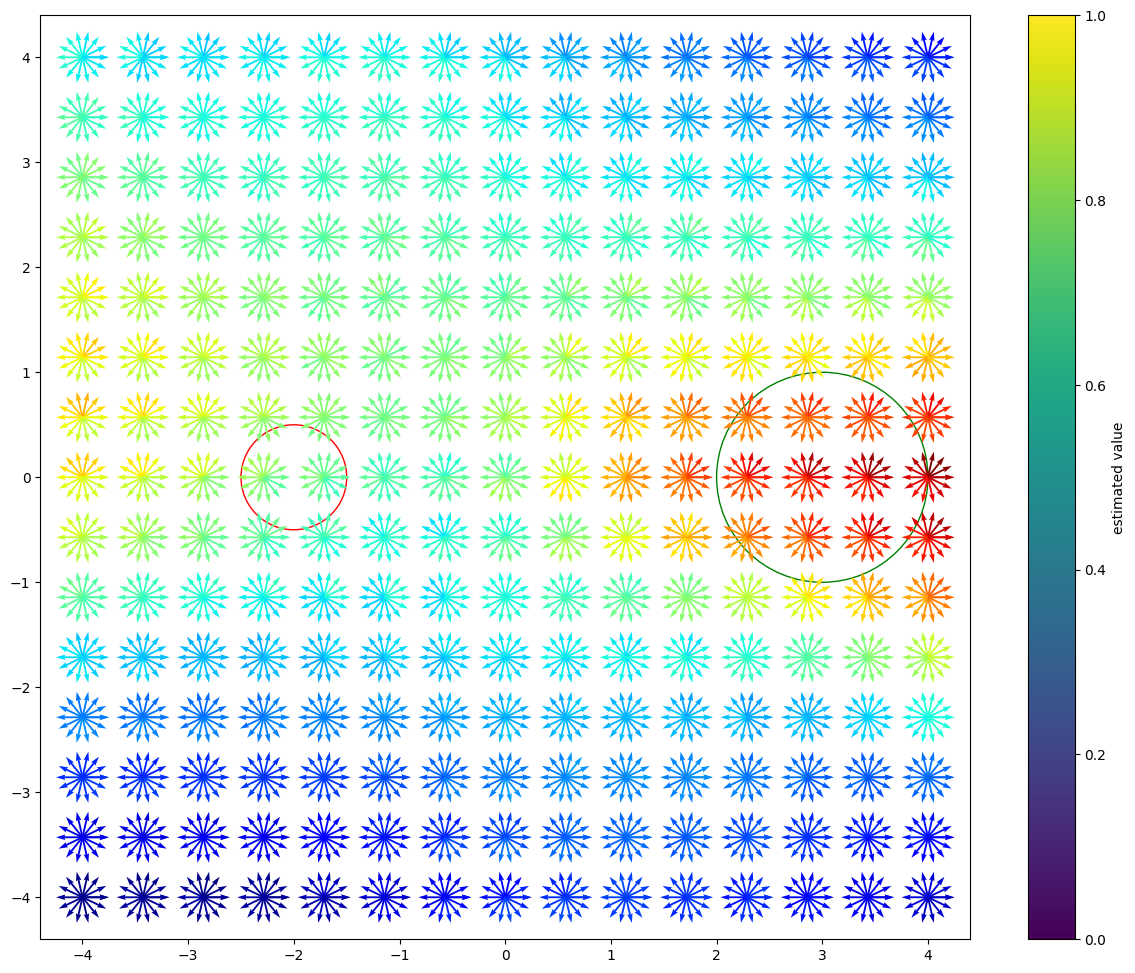

In [ ]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

In [ ]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


In [ ]:
pa[best_defender_move][best_attacker_move]

In [ ]:
possible_actions